In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))


In [2]:
import sys
sys.path.append('/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/')
import DCTR
import numpy as np
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py'>

# load data

In [4]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0

X0_nrm = []
X1_nrm = []

# MiNNLO
X1_nrm = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/normed_lhe.npz'))
print('MiNNLO all particles X1.shape: '+str(X1_nrm.shape))

# POWHEG hvq
X0_nrm = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/normed_lhe.npz'))
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))


MiNNLO all particles X1.shape: (9553938, 3, 9)
POWHEG hvq all particles X0.shape: (29605180, 3, 9)


In [5]:
# [pt, rapidity, phi, mass, pseudorapidity, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4             , 5, 6  , 7, 8    ]

# delete pseudorpaidity (eta) because it was giving me problems
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


In [19]:
# truncate the arrays to the length of the shorter one, so that both arrays have the same number of events

X0, X1 = DCTR.trim_datasets(X0_nrm.copy(), X1_nrm.copy())

print('POWHEG hvq all particles X0.shape: '+str(X0.shape))
print('MiNNLO all particles X1.shape: '+str(X1.shape))


POWHEG hvq all particles X0.shape: (9553938, 3, 8)
MiNNLO all particles X1.shape: (9553938, 3, 8)


# Neural Positive Reweighter

In [20]:
wgt_org = X1[:,0,6].copy() # would be arg 7, but we removed eta above


In [21]:
# neural positive reweigher for MiNNLO X1
from energyflow.utils import to_categorical
from sklearn.model_selection import train_test_split

x = np.concatenate([X1,X1]) # two identical copies
wgt = np.concatenate([wgt_org, np.ones(len(wgt_org))]) # wgts as is and all = 1 

y = np.concatenate([np.ones(len(X1)),np.zeros(len(X1))]) # identifier 
y = to_categorical(y, num_classes=2) # encode y as one hot

# split x, y, wgt into random training and validation datasets
X_rwgt_train, X_rwgt_val, Y_rwgt_train, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val = train_test_split(x[...,:-2], y, wgt, test_size=0.15) 

x = []
y = []
wgt = []


Starting training
Epoch 1/40
247/248 [============================>.] - ETA: 0s - loss: 0.6284 - acc: 0.5000
Epoch 1: val_loss improved from inf to 0.61770, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
248/248 [==============================] - 7s 23ms/step - loss: 0.6284 - acc: 0.5000 - val_loss: 0.6177 - val_acc: 0.4999 - lr: 0.0010
Epoch 2/40
247/248 [============================>.] - ETA: 0s - loss: 0.6170 - acc: 0.4999
Epoch 2: val_loss improved from 0.61770 to 0.61687, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
248/248 [==============================] - 5s 22ms/step - loss: 0.6170 - acc: 0.4999 - val_loss: 0.6169 - val_acc: 0.4998 - lr: 0.0010
Epoch 3/40
247/248 [============================>.] - ETA: 0s - loss: 0.6165 - acc: 0.4999
Epoch 3: val_loss improved from 0.61687 to 0.61673, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06

Epoch 24/40
247/248 [============================>.] - ETA: 0s - loss: 0.6156 - acc: 0.5000
Epoch 24: val_loss did not improve from 0.61596
248/248 [==============================] - 5s 21ms/step - loss: 0.6156 - acc: 0.5000 - val_loss: 0.6160 - val_acc: 0.4999 - lr: 8.4366e-04
Epoch 25/40
247/248 [============================>.] - ETA: 0s - loss: 0.6156 - acc: 0.5000
Epoch 25: val_loss improved from 0.61596 to 0.61592, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
248/248 [==============================] - 5s 22ms/step - loss: 0.6156 - acc: 0.5000 - val_loss: 0.6159 - val_acc: 0.5000 - lr: 8.2696e-04
Epoch 26/40
246/248 [============================>.] - ETA: 0s - loss: 0.6155 - acc: 0.5000
Epoch 26: val_loss improved from 0.61592 to 0.61590, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
248/248 [==============================] - 5s 22ms/step - 

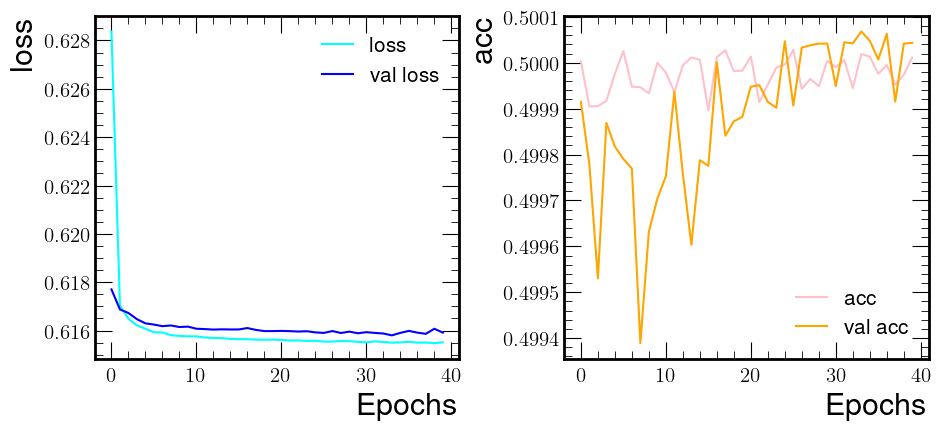

In [22]:
# train positive reweighing neural network

pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10)) # compiling model with different sizes clears weights

pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=12, saveLabel='DCTR_X1_MiNNLO_positive_reweighing')

dctr.load_weights('DCTR_X1_MiNNLO_positive_reweighing.h5')
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*8, epochs=60, saveLabel='DCTR_X1_MiNNLO_positive_reweighing')


In [23]:
# load neural positive resampler training
pos_rwgt, _ = DCTR.setup_nn(input_dim=6)
pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing.h5') # trained previously

# make prediction 
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    rwgt_pred = pos_rwgt.predict(X1[...,:-2], batch_size = 4096, verbose=1) # without wgt and theta parameters, they are the last two parameters

# positive weights from predictions
wgt_pos = rwgt_pred[:,1] / rwgt_pred[:,0]

# adjust weights so that mean is 1, so that both datasets are equally important
wgt_pos /= np.mean(wgt_pos) 

print(np.mean(wgt_pos))



2333/2333 [==============================] - 10s 4ms/step
1.0000005


[1. 1. 1. ... 1. 1. 1.]
[0.66345835 0.7838156  1.0003887  ... 0.7881619  0.6501608  1.0351983 ]


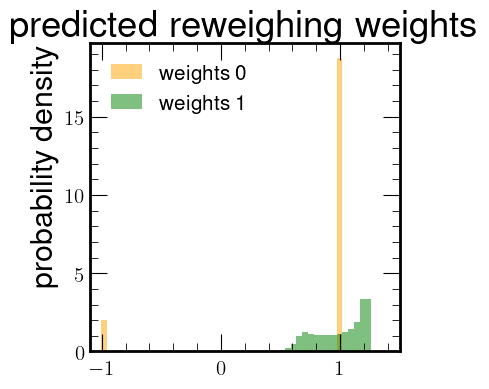

In [24]:
# give new positive weights to X1 MiNNLO dataset
X1[...,6] = wgt_pos[:, np.newaxis] # would be arg 7, but we removed eta above

print(wgt_org)
print(wgt_pos)

DCTR.plot_weights(wgt_org, wgt_pos, start=-1.1, stop=1.5, div=55)


In [25]:
# plot validation graphs

9435432out of 9553938 events (98.76%) are between $p_{T}$ [GeV] -3 and 3


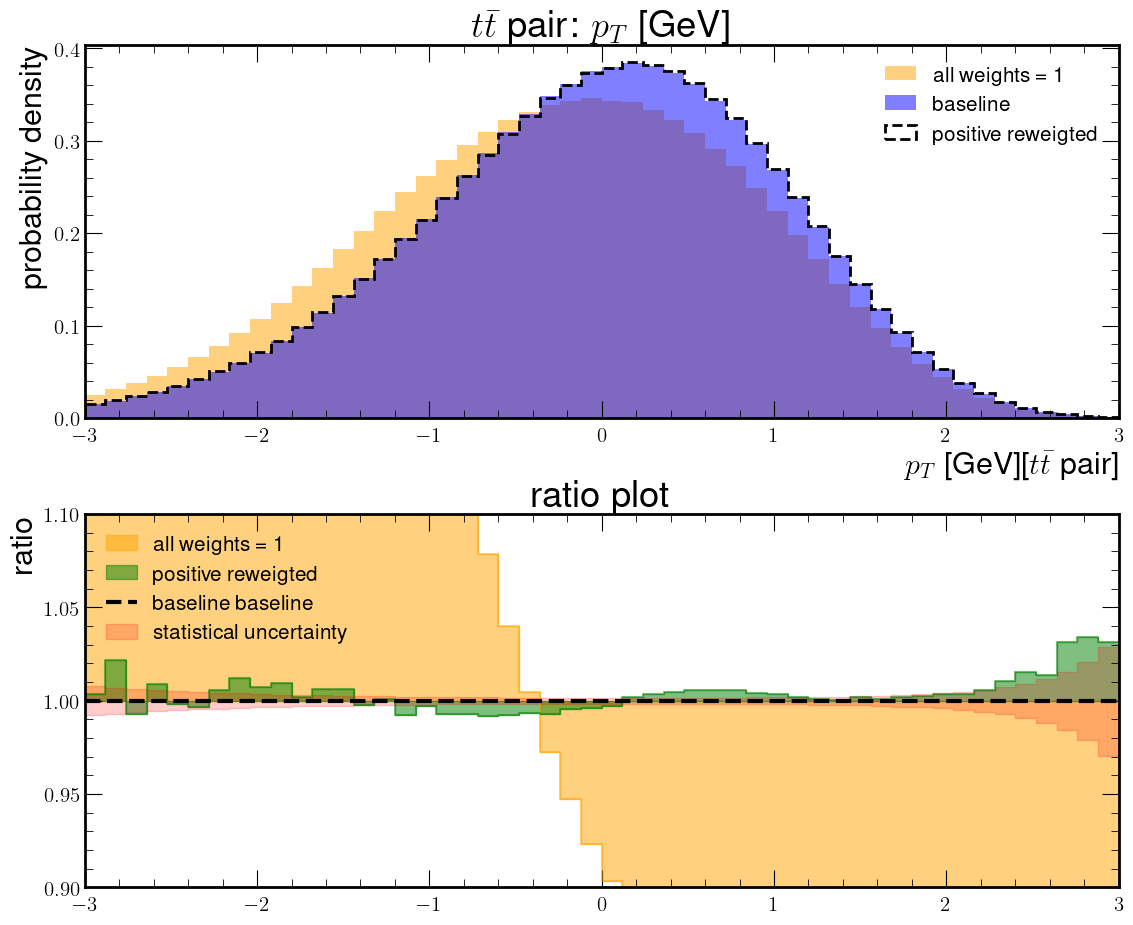

In [26]:
DCTR.plot_3_ratio(X1_nrm, X1_nrm, X1_nrm, arg_index = 0, part_index=1, start=0, stop=450, div = 51,
                  X0_wgt = 1, X1_wgt = wgt_org, X2_wgt = wgt_pos, X0_label = 'all weights = 1', X1_label = 'baseline', X2_label = 'positive reweigted')


9435432out of 9553938 events (98.76%) are between $p_{T}$ [GeV] -3 and 3


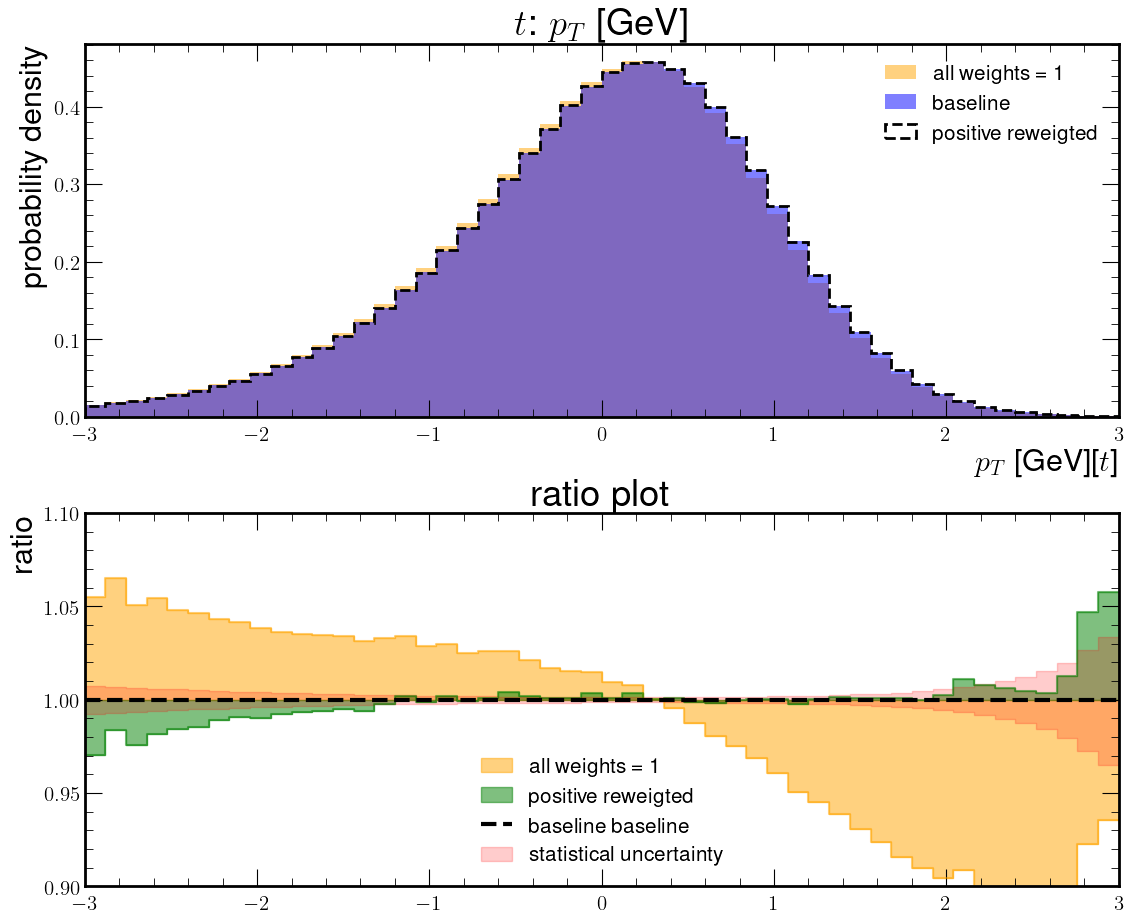

In [28]:
DCTR.plot_3_ratio(X1, X1, X1, arg_index = 0, part_index=1, start=-3, stop=3, div = 51, 
                  X0_wgt = 1, X1_wgt = wgt_org, X2_wgt = wgt_pos, X0_label = 'all weights = 1', X1_label = 'baseline', X2_label = 'positive reweigted')


# Preparing Datasets for Training

In [29]:
# prep arrays for the neural network
# Strips the theta parameter off the datasets and creates a one-hot classifier array Y
# Also strips the weights off the datasets and creates a weights array
# The Datasets are combined and returned shuffled (by default) 
# 15% (by default) are taken for the evaluation sets and the rest are used for the training
# returns: X_train, X_val, Y_train, Y_val, wgt_train, wgt_val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0.copy(), X1.copy()) # defaults: val=0.15, shuffle=True, use_class_weights=False

# clear previous temp arrays from memory
# X0 = []
# X1 = []


In [30]:
wgt_train = np.abs(wgt_train)
wgt_val = np.abs(wgt_val)



# prep and train DCTR neural network

Starting training
Epoch 1/500
247/248 [============================>.] - ETA: 0s - loss: 0.6616 - acc: 0.5564
Epoch 1: val_loss improved from inf to 0.66153, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
248/248 [==============================] - 8s 27ms/step - loss: 0.6616 - acc: 0.5563 - val_loss: 0.6615 - val_acc: 0.5546 - lr: 0.0010
Epoch 2/500
246/248 [============================>.] - ETA: 0s - loss: 0.6613 - acc: 0.5551
Epoch 2: val_loss did not improve from 0.66153
248/248 [==============================] - 7s 26ms/step - loss: 0.6613 - acc: 0.5551 - val_loss: 0.6616 - val_acc: 0.5538 - lr: 0.0010
Epoch 3/500
247/248 [============================>.] - ETA: 0s - loss: 0.6612 - acc: 0.5551
Epoch 3: val_loss did not improve from 0.66153
248/248 [==============================] - 7s 27ms/step - loss: 0.6612 - acc: 0.5551 - val_loss: 0.6616 - val_acc: 0.5519 - lr: 0.0010
Epoch 4/500
246/248 [============================>.] - ETA: 0s 

Epoch 29/500
247/248 [============================>.] - ETA: 0s - loss: 0.6606 - acc: 0.5558
Epoch 29: val_loss did not improve from 0.66121
248/248 [==============================] - 6s 26ms/step - loss: 0.6606 - acc: 0.5558 - val_loss: 0.6612 - val_acc: 0.5523 - lr: 7.6338e-04
Epoch 30/500
247/248 [============================>.] - ETA: 0s - loss: 0.6606 - acc: 0.5559
Epoch 30: val_loss did not improve from 0.66121
248/248 [==============================] - 7s 27ms/step - loss: 0.6606 - acc: 0.5559 - val_loss: 0.6614 - val_acc: 0.5545 - lr: 7.4826e-04
Epoch 31/500
246/248 [============================>.] - ETA: 0s - loss: 0.6606 - acc: 0.5557
Epoch 31: val_loss did not improve from 0.66121
248/248 [==============================] - 7s 26ms/step - loss: 0.6606 - acc: 0.5557 - val_loss: 0.6614 - val_acc: 0.5509 - lr: 7.3345e-04
Epoch 32/500
246/248 [============================>.] - ETA: 0s - loss: 0.6606 - acc: 0.5561
Epoch 32: val_loss did not improve from 0.66121
248/248 [==========

248/248 [==============================] - 7s 28ms/step - loss: 0.6603 - acc: 0.5564 - val_loss: 0.6612 - val_acc: 0.5528 - lr: 4.4486e-04
Epoch 57/500
247/248 [============================>.] - ETA: 0s - loss: 0.6604 - acc: 0.5563
Epoch 57: val_loss did not improve from 0.66094
248/248 [==============================] - 7s 28ms/step - loss: 0.6604 - acc: 0.5563 - val_loss: 0.6611 - val_acc: 0.5516 - lr: 4.3605e-04
Epoch 58/500
246/248 [============================>.] - ETA: 0s - loss: 0.6603 - acc: 0.5564
Epoch 58: val_loss did not improve from 0.66094
248/248 [==============================] - 7s 28ms/step - loss: 0.6603 - acc: 0.5564 - val_loss: 0.6611 - val_acc: 0.5519 - lr: 4.2742e-04
Epoch 59/500
248/248 [==============================] - ETA: 0s - loss: 0.6603 - acc: 0.5565
Epoch 59: val_loss did not improve from 0.66094
248/248 [==============================] - 7s 28ms/step - loss: 0.6603 - acc: 0.5565 - val_loss: 0.6610 - val_acc: 0.5535 - lr: 4.1895e-04
Epoch 60/500
246/248 

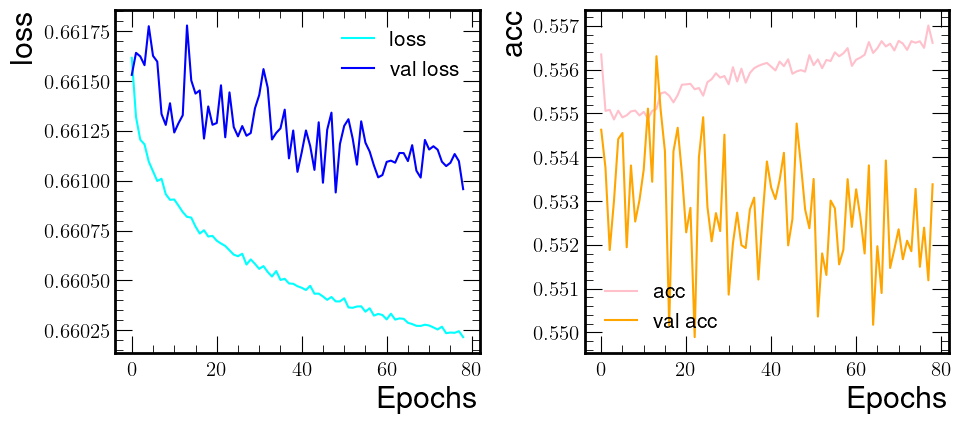

In [31]:
''' setup_nn() defaults
input_dim=7, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
use_custom_loss=False, dropout=0.0, l2_reg=0.0, learning_rate=0.001,
patience=10, use_scheduler=True, use_focal=False, gamma=1.1,
monitor='val_loss', mode='min', savePath=currentPath,
saveLabel='DCTR_training', summary=False
'''
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,12), F_sizes = (10,10,10)) # compiling model with different sizes clears weights
                                
#initialize training
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.15, l2_reg=5e-7, patience=30)

dctr.load_weights('DCTR_training.h5')
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*8)


Starting training
Epoch 1/500
246/248 [============================>.] - ETA: 0s - loss: 0.6601 - acc: 0.5564
Epoch 1: val_loss improved from inf to 0.66002, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
248/248 [==============================] - 8s 29ms/step - loss: 0.6600 - acc: 0.5564 - val_loss: 0.6600 - val_acc: 0.5556 - lr: 0.0010
Epoch 2/500
246/248 [============================>.] - ETA: 0s - loss: 0.6600 - acc: 0.5567
Epoch 2: val_loss did not improve from 0.66002
248/248 [==============================] - 7s 28ms/step - loss: 0.6600 - acc: 0.5567 - val_loss: 0.6601 - val_acc: 0.5550 - lr: 0.0010
Epoch 3/500
248/248 [==============================] - ETA: 0s - loss: 0.6600 - acc: 0.5566
Epoch 3: val_loss improved from 0.66002 to 0.65998, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
248/248 [==============================] - 7s 28ms/step - loss: 0.6600 - acc: 0.5566 - val_loss: 

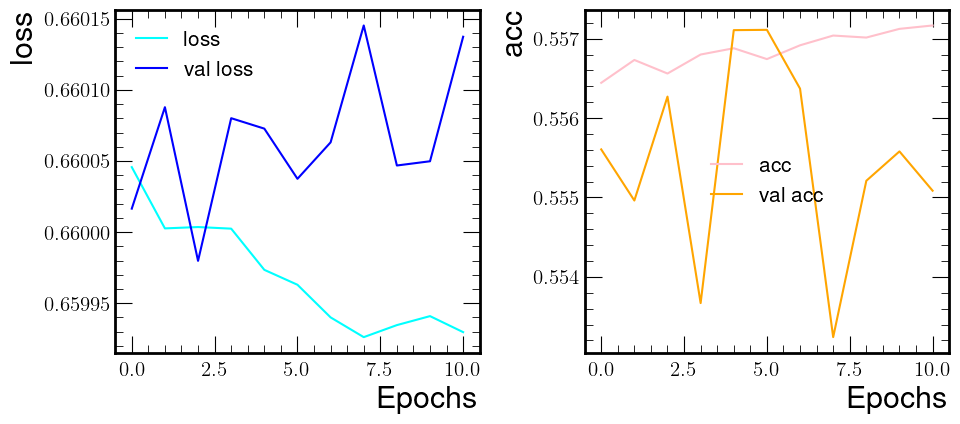

In [34]:
#continue training
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.02, patience=8)

dctr.load_weights('DCTR_training.h5')
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*8)


# verify DCTR predictions

In [6]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays

# POWHEG hvq
X0_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/converted_lhe.npz'))
X0_test = DCTR.remove_jet_parts(X0_test)

# MiNNLO
X1_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/converted_lhe.npz'))
X1_test = DCTR.remove_jet_parts(X1_test)

print('MiNNLO     X1_test.shape: '+str(X1_test.shape))
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))


MiNNLO     X1_test.shape: (9553938, 3, 9)
POWHEG hvq X0_test.shape: (29605180, 3, 9)


# load training and predict weights

In [7]:
# load training
dctr, callbacks = DCTR.setup_nn(input_dim = 6)
dctr.load_weights('DCTR_training.h5')


1167/1167 [==============================] - 8s 7ms/step


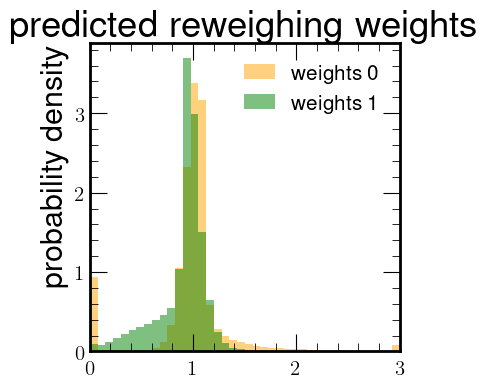

In [35]:
#plot weights
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    weights_0, weights_1 = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2])

DCTR.plot_weights(weights_0, weights_1, start=0, stop=3, div=41)


In [9]:
X0_nrm_wgt = X0_nrm[:, 0, 6] # would be arg 7, but we removed eta above
X1_nrm_wgt = X1_nrm[:, 0, 6]

print(X0_nrm_wgt)
print(X1_nrm_wgt)


[1.         1.         1.         ... 0.99930382 0.99930382 0.99930382]
[-1.  1. -1. ...  1.  1.  1.]


# check and plot DCTR predictions

In [10]:
# tt-pair

29601384out of 29605180 events (99.99%) are between $p_{T}$ [GeV] 0 and 1000


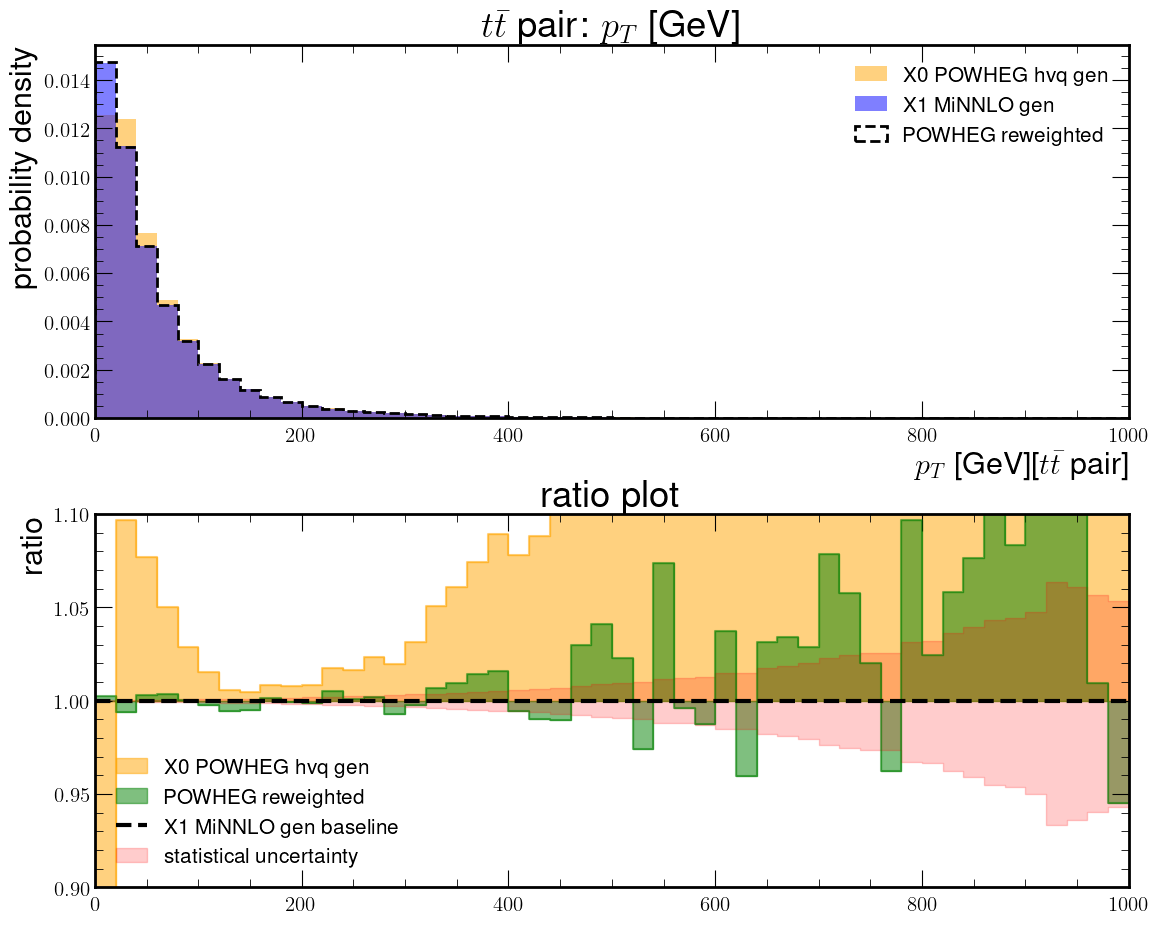

In [54]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, start=0, stop=1000, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))

29594504out of 29605180 events (99.96%) are between $\eta$ pseudorapidity -8 and 8


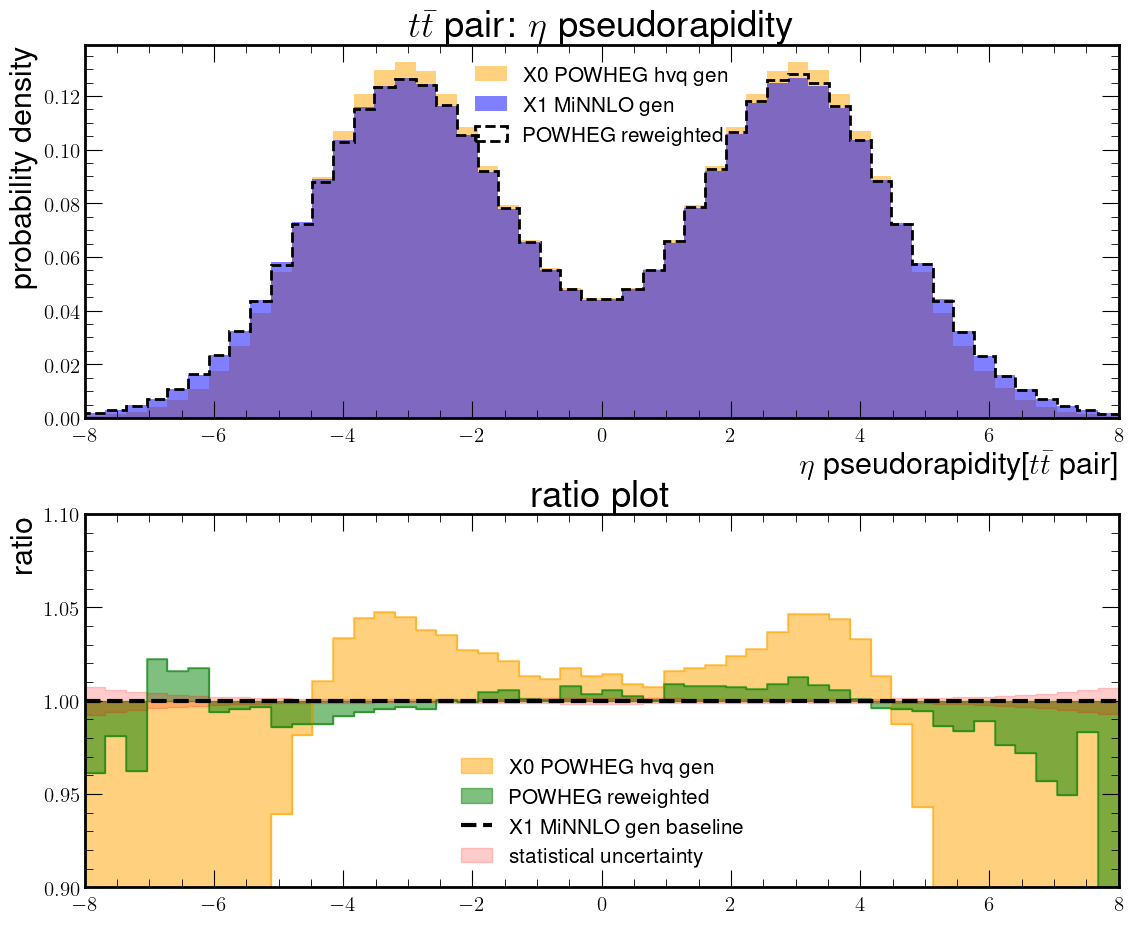

In [56]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 4, start=-8, stop=8, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [38]:
# top quark

29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


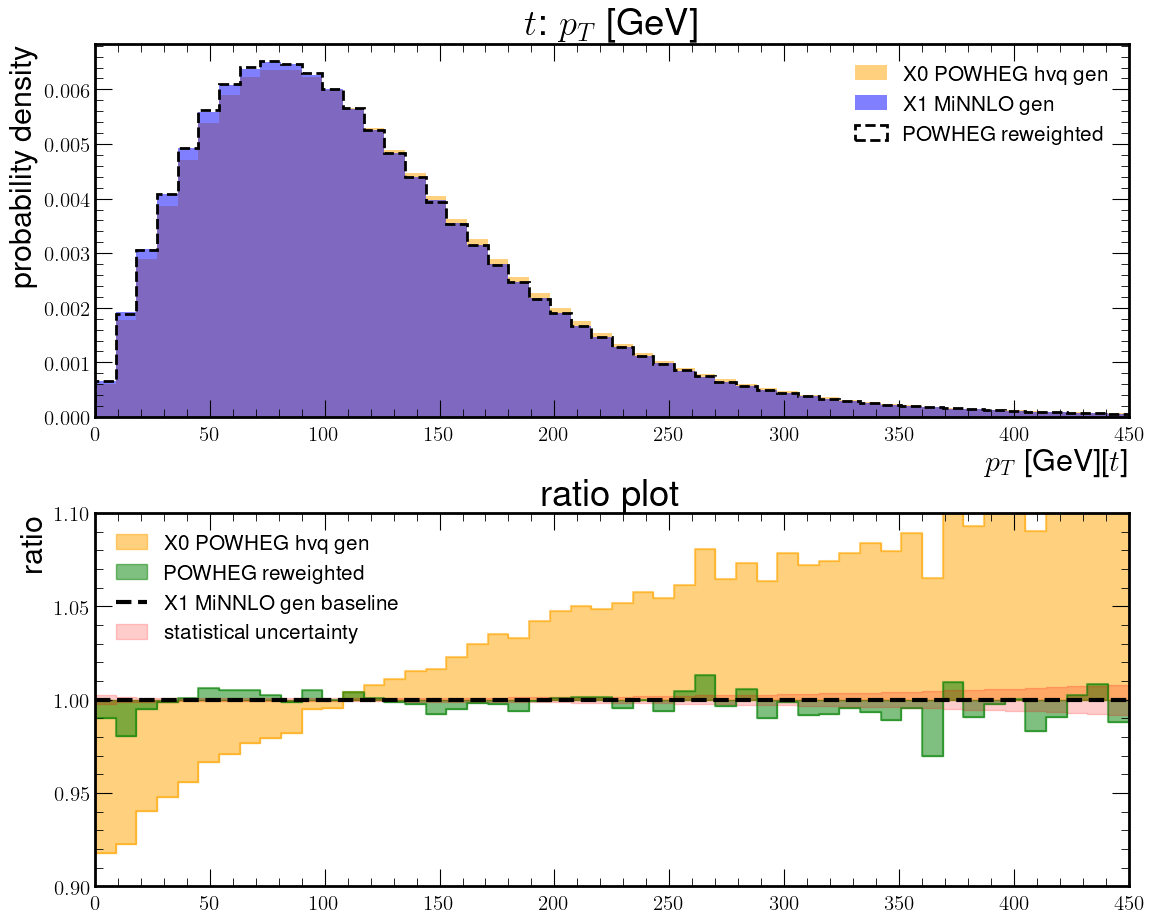

In [39]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 1, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


0out of 29605180 events (0.0%) are between mass [GeV] 160 and 180


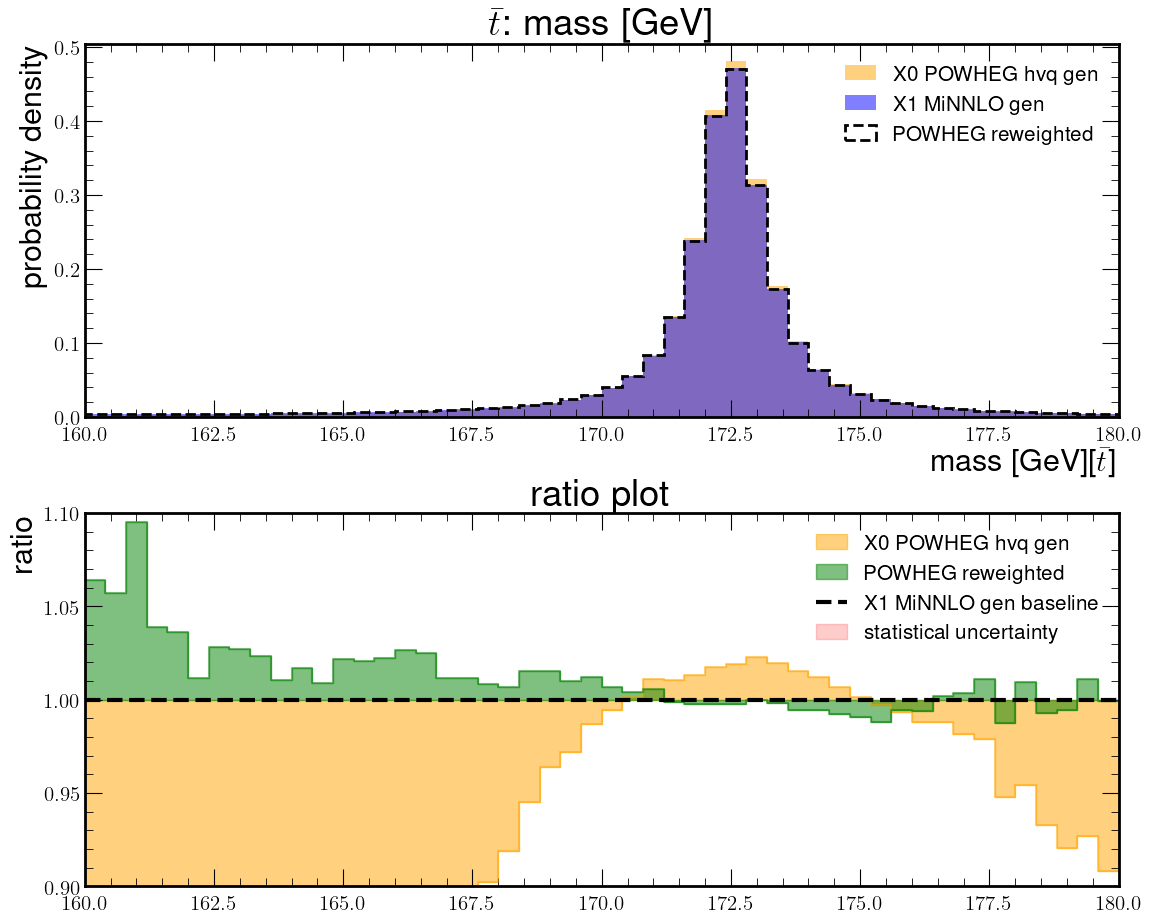

In [40]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [41]:
# anti-top

29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


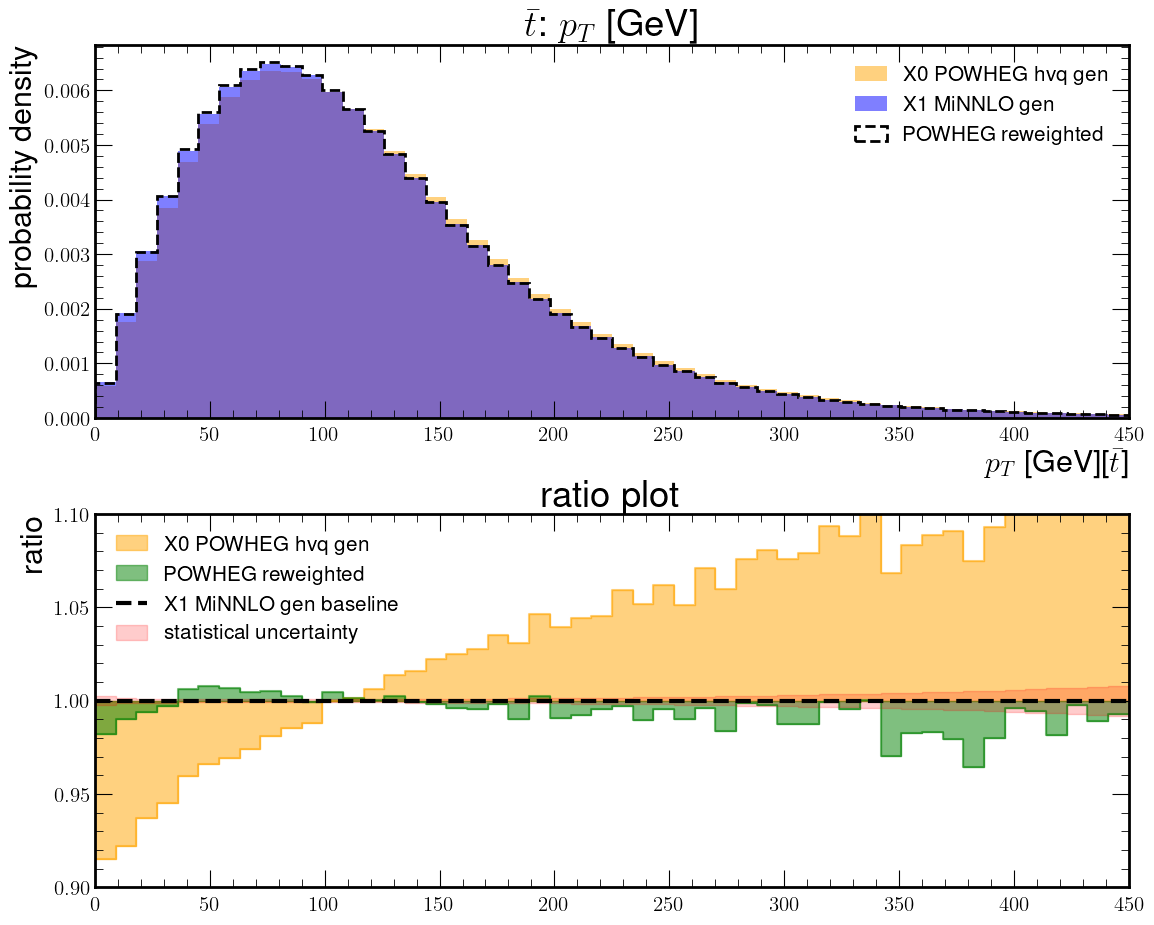

In [42]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 2, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


0out of 29605180 events (0.0%) are between mass [GeV] 160 and 180


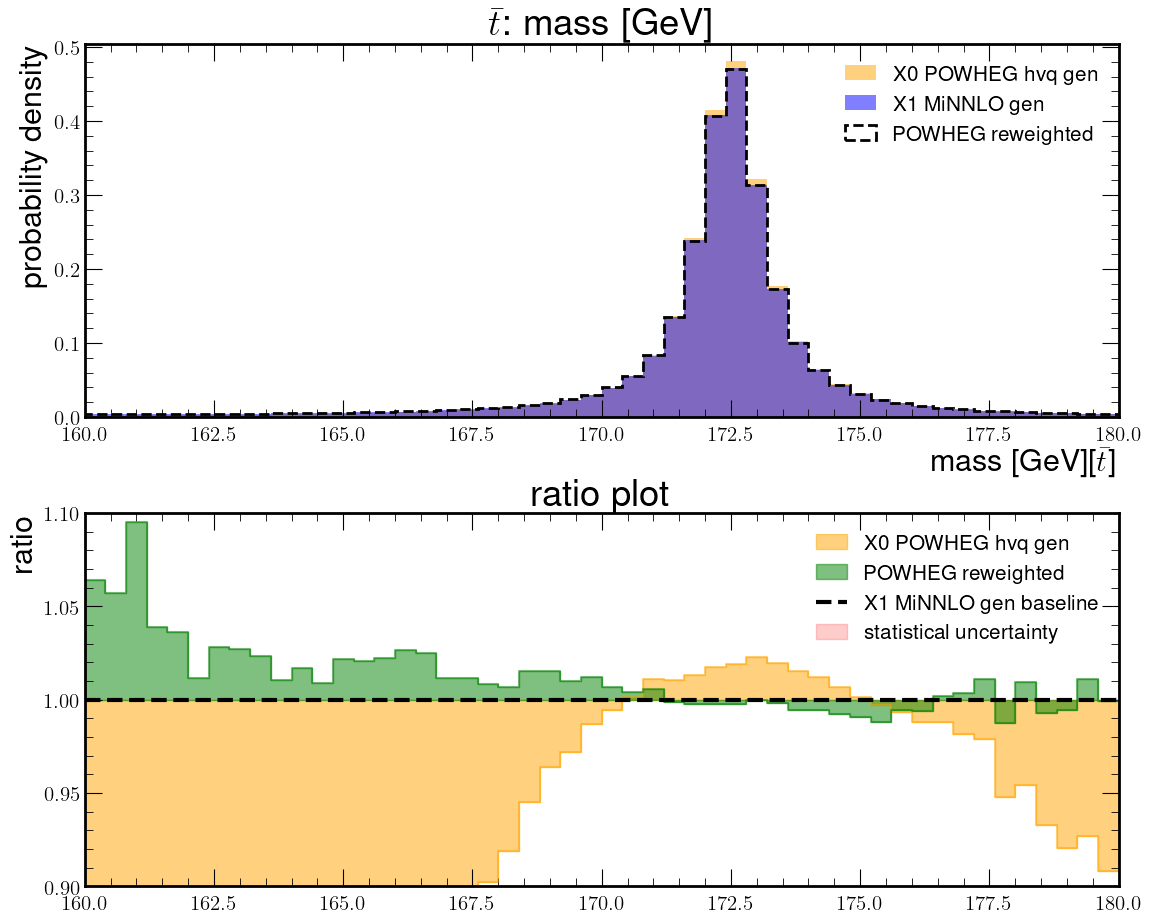

In [43]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


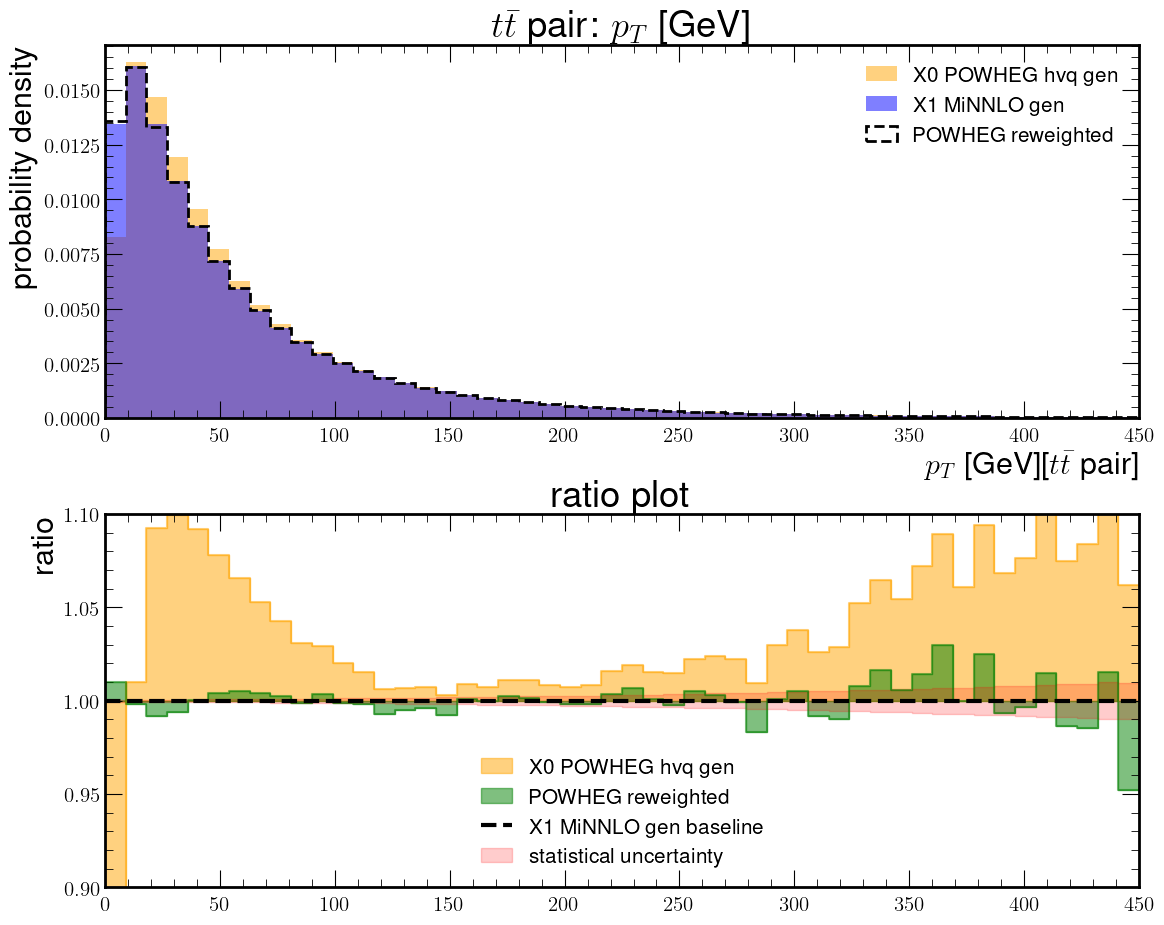

29605180out of 29605180 events (100.0%) are between $\gamma$ rapidity -8 and 8


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:917: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(bins, (n0/n1), alpha=0.5, color='orange', where='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:918: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(bins, n0/n1, 1, label = X0_label, alpha=0.5, color='orange', step='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:920: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(bins, (n2/n1), alpha=0.5, color='green', where='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:921: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(bins, n2/n1, 1, label = X2_label, alpha=0.5, color='green', step='post')


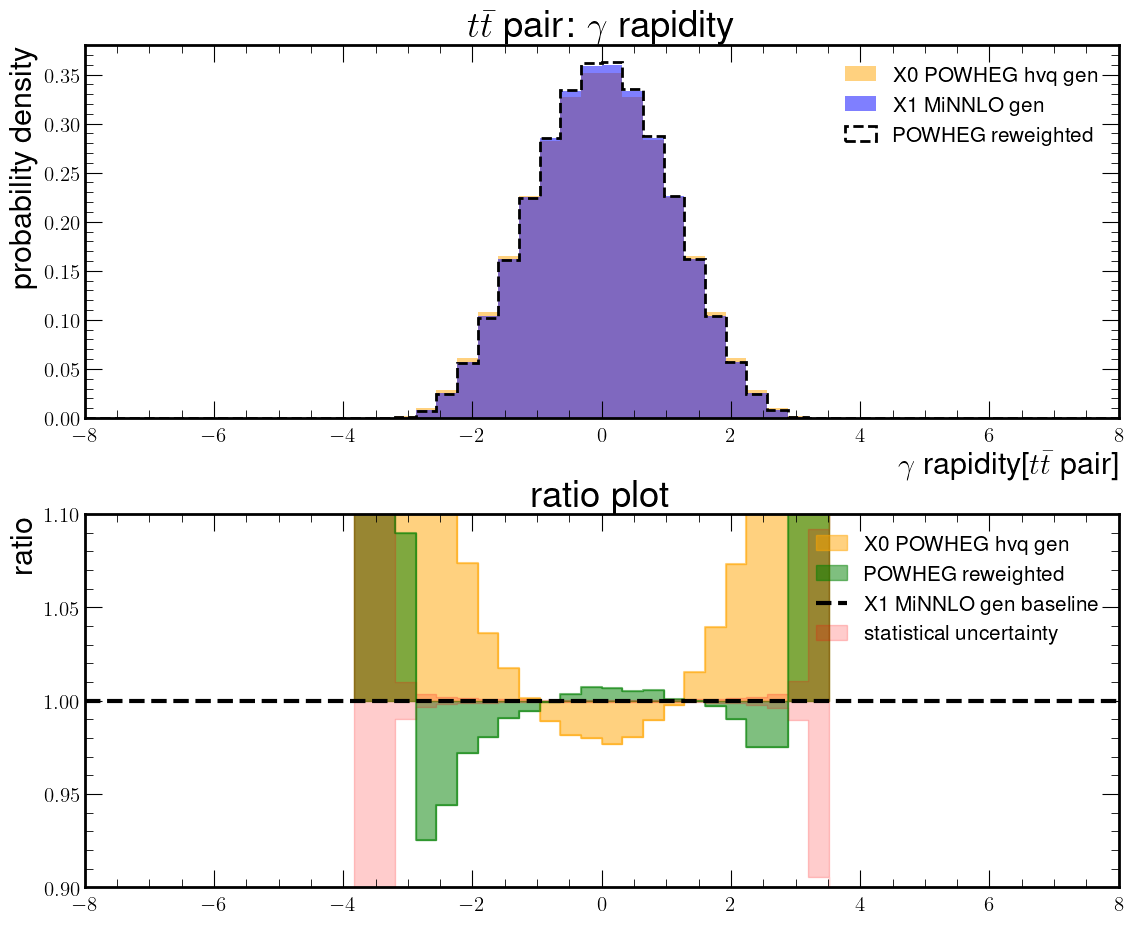

29605180out of 29605180 events (100.0%) are between $\phi$ -8 and 8


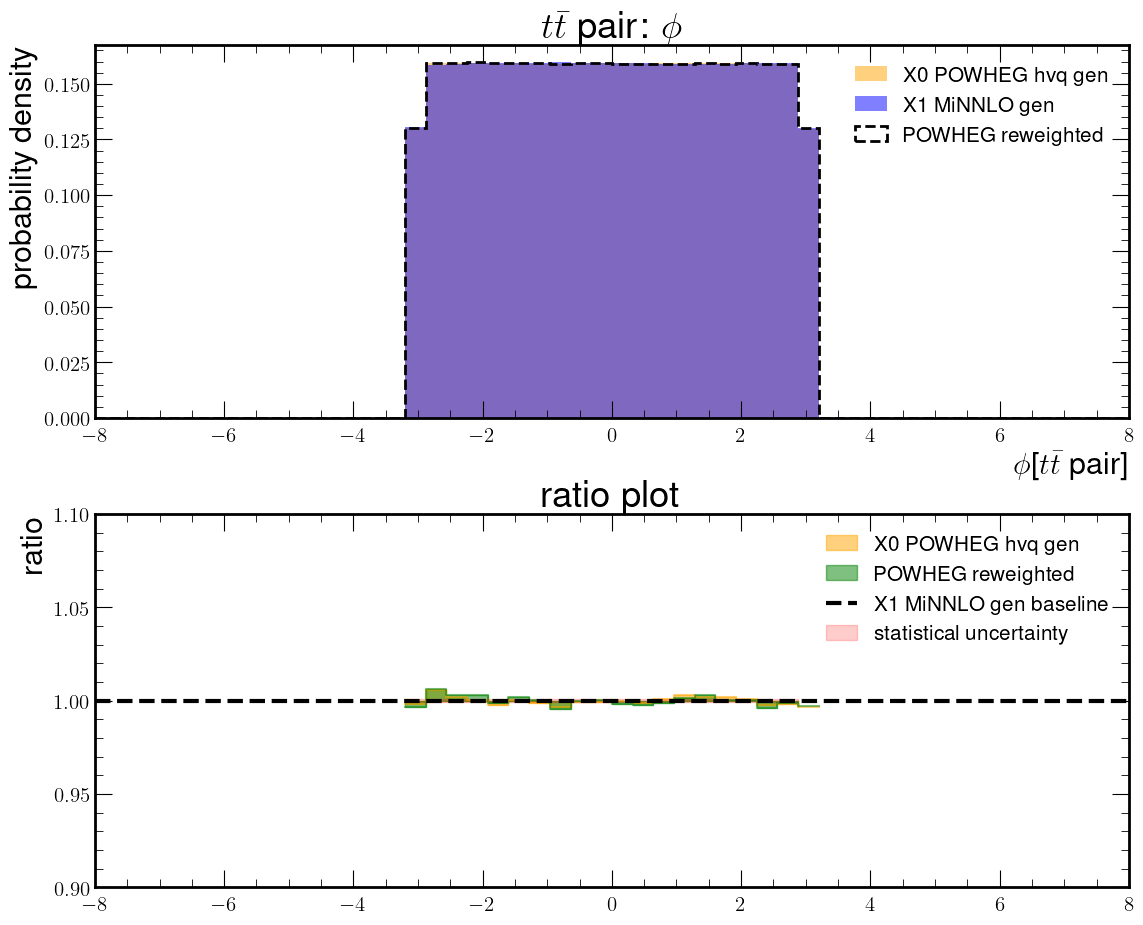

In [ ]:
for part in range(3):
    start=0
    stop=450
    div = 51
    for arg in range(6):
        if arg == 1 or arg == 2 or arg == 4:
            start = -8
            stop = 8
        elif arg == 3 or arg == 5:
            start=0
            stop=1000
        DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = arg, part_index = part, start=start, stop=stop, div = div, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))

In [57]:
import matplotlib.pyplot as plt
plt.show()
